# Simple 1/V estimator
Source: doi:10.1093/mnras/stw756 (page 7)

## Imports, initial values

In [1]:
import numpy as np
from astropy.coordinates import Distance
from astropy.table import Table, hstack
from astropy.cosmology import Planck18
from astropy import units as u
import astropy.constants as asc
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import corner
import arviz as az

from astropy.modeling.models import Schechter1D
from astropy.modeling import models, fitting

# custom GAlaxy SELection functions
import gasel as gs

Complete Sky area in deg^2

In [2]:
omega_sky = 41253 #

In [3]:
min_ra = 190
min_dec = -5
max_ra = 220
max_dec = 5
buffer = 2.0

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 299.62 sqdeg


## Functions

define the functions that calculate the V_max & luminosity limit

In [135]:
def V_max(omega_s, z_min, z_max_lum):
    """
    Description: Calculates the maximum Volume in which the source could have been detected in: corrects for the so-called "Malmquist-bias"
    (faint objects, which usually also means low mass objects, will only be covered in a survey within a smaller volume than bright and high-mass
    objects)
    
    Params:
    omega_s: surface area covered by the complete data
    z_min: lower redshift limit of sample
    z_max_lum: maximum redshift determined for for object based on luminosity and its completeness 
    (i.e. maximum redshift at which the source with luminosity l would no longer be part of the sample)
    
    """
    z_max = np.minimum(z_max_data, z_max_lum)
    return 4/3*np.pi * omega_s/omega_sky * (Distance(z=z_max, cosmology=Planck18)**3-Distance(z=z_min, cosmology=Planck18)**3)

In [136]:
def lum_lim(lum, m_lim, m):
    """
    Calculate the luminosity a source would have if its magnitude was equal to the DESI magnitude limit (have to research the value)
    
    Params:
    - lum: luminosity of an object
    - m_lim: magnitude limit of the survey
    - m: apparent magnitude of an object
    
    """
    return lum*10**(-0.4*(m_lim-m))

In [137]:
def calc_kcor(filter_name, redshift, colour_name, colour_value):
    """
    K-corrections calculator in Python. See http://kcor.sai.msu.ru for the 
    reference. Available filter-colour combinations must be present in the 
    `coeff` dictionary keys.

    @type   filter_name: string    
    @param  filter_name: Name of the filter to calculate K-correction for, e.g. 
                         'u', 'g', 'r' for some of the SDSS filters, or 'J2', 
                         'H2', 'Ks2' for 2MASS filters (must be present in 
                         `coeff` dictionary)
    @type      redshift: float    
    @param     redshift: Redshift of a galaxy, should be between 0.0 and 0.5 (no
                         check is made, however)
    @type   colour_name: string    
    @param  colour_name: Human name of the colour, e.g. 'u - g', 'g - r', 
                         'V - Rc', 'J2 - Ks2' (must be present in `coeff` dictionary)
    @type  colour_value: float    
    @param colour_value: Value of the galaxy's colour, specified in colour_name    
    @rtype:              float
    @return:             K-correction in specified filter for given redshift and 
                         colour
    @version:            2012
    @author:             Chilingarian, I., Melchior. A.-L., and Zolotukhin, I.
    @license:            Simplified BSD license, see http://kcor.sai.msu.ru/license.txt

    Usage example:
    
        >>> calc_kcor('g', 0.2, 'g - r', 1.1)
        0.5209713975999992
        >>> calc_kcor('Ic', 0.4, 'V - Ic', 2.0)
        0.310069919999993
        >>> calc_kcor('H', 0.5, 'H - K', 0.1)
        -0.14983142499999502
        
    """
    coeff = {

        'r_gr': [
            [0,0,0,0],
            [1.83285,-2.71446,4.97336,-3.66864],
            [-19.7595,10.5033,18.8196,6.07785],
            [33.6059,-120.713,-49.299,0],
            [144.371,216.453,0,0],
            [-295.39,0,0,0],
        ], 
        'g_gz': [
            [0,0,0,0],
            [2.37454,-4.39943,7.29383,-2.90691],
            [-28.7217,-20.7783,18.3055,5.04468],
            [220.097,-81.883,-55.8349,0],
            [-290.86,253.677,0,0],
            [-73.5316,0,0,0],
        ],
        'z_gz': [
            [0,0,0,0],
            [0.30146,-0.623614,1.40008,-0.534053],
            [-10.9584,-4.515,2.17456,0.913877],
            [66.0541,4.18323,-8.42098,0],
            [-169.494,14.5628,0,0],
            [144.021,0,0,0],
        ]

    }

    c = coeff[filter_name + '_' + colour_name.replace(' - ', '')]
    kcor = 0.0

    for x, a in enumerate(c):
        for y, b in enumerate(c[x]):
            kcor += c[x][y] * redshift**x * colour_value**y

    return kcor

In [138]:
def app_mag(flux):
    """
    Calculate the apparent magnitude from the flux
    INput: numpy array
    """
    return 22.5-2.5*np.log10(flux)

In [139]:
def abs_mag(m, z, band, color_name, color):
    #return m - 5*np.log10(Distance(z=z, cosmology=Planck18)/u.Mpc*10**6)+5 - calc_kcor(band, z, color_name, color)
    return m - 5*np.log10(Distance(z=z, cosmology=Planck18)/u.Mpc*10**6)+5

## Load the data & prepare/select

In [140]:
# Release directory path

specprod = 'iron'    # Internal name for most current data release
specprod_dir = '/global/cfs/cdirs/desi/spectro/redux/iron/'
print(specprod_dir)

/global/cfs/cdirs/desi/spectro/redux/iron/


In [141]:
ztile_cat = Table.read(f'{specprod_dir}/zcatalog/zall-tilecumulative-{specprod}.fits', hdu="ZCATALOG")

In [142]:
ztile_cat[200000:200002]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bool,int32,bool,int64,bool
2305843042172556950,main,backup,20220315,20220315,-3.00809916038518e-05,8.17084131088571e-06,0,8122.131242808256,2642.9873816104127 .. 0.0,7926,STAR,K,5,1731.7716519866854,6,134,6134,3336,0,236.1111659842606,2.4452757496874202,6.997798,-4.627603,2015.5,5400.0,2305843009213693952,1,TGT,-144.61711,140.12033,25,0.5627646015238863,568,-1,--,345712,-1,GPSF,0.09782427,-99.0,-99.0,-99.0,0.0,0.0,-99.0,-99.0,-99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,4423852667484346112,G2,18.6984,19.790138,17.672045,0.82504624,G,25,2,0,2305843009213693952,0,288230376151711744,0,0,0,0,0,0,0,0,0,0,0,0,0,236.1111659842606,2.4452757496874202,40280,2,855.4842,2,1,0.00330267,0.004675114,0.0013395663,0.0014562567,236.11117934202923,0.04800739,2.445270189679835,0.0077114785,0.7914041,-144.5933,140.08015,12.523476,0.0053837355,2.5068247,3.1788597,33.164173,19.253931,0.122836754,0.0615563,620.75806,1.7215315,123.98336,0.0015768304,136.13423,911.63226,0.394868,2.4228117,9.204132e-07,6.9117856,1.8511989e-07,0.0,311.3585,1.4048325e-06,1.1787453,3.1866295,633.28156,8.6387005,126.49019,3.1804366,480.6569,930.88617,1.69645,5.6709976,1,True,0,False,1,True
2305843042176741438,main,backup,20220315,20220315,-0.00019829921610947787,3.6222601546171266e-07,0,93622.25726952829,885048.021980

In [143]:
ztile_cat.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'LASTNIGHT', 'SPECTYPE'])

In [144]:
ii = ztile_cat['TARGET_RA']>(min_ra)
ii &= ztile_cat['TARGET_RA']<(max_ra)
ii &= ztile_cat['TARGET_DEC']>(min_dec)
ii &= ztile_cat['TARGET_DEC']<(max_dec)

# ztile_cat = ztile_cat[ii]
print("All entries after localization selection", len(ztile_cat))

All entries after localization selection 30300000


In [145]:
ztile_cat = ztile_cat[ztile_cat["PROGRAM"] == "bright"]

In [146]:
print("All entries in BRIGHT data: ", len(ztile_cat))

All entries in BRIGHT data:  12782500


In [147]:
ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [148]:
ztile_cat = ztile_cat[ztile_cat['Z']>=0]
print("All entries after good redshift selection", len(ztile_cat))

All entries after good redshift selection 8343821


In [149]:
ztile_cat = ztile_cat[ztile_cat["FLUX_Z"] > 0.0]
print("All entries after Flux Z selection", len(ztile_cat))

All entries after Flux Z selection 8244532


In [150]:
ztile_cat = ztile_cat[ztile_cat["FLUX_R"] > 0.0]
print("All entries after Flux R selection", len(ztile_cat))

All entries after Flux R selection 8244487


In [151]:
ztile_cat = ztile_cat[ztile_cat["FLUX_G"] > 0.0]
print("All entries after Flux G selection", len(ztile_cat))

All entries after Flux G selection 8244131


In [152]:
ztile_cat = ztile_cat[ztile_cat["SPECTYPE"] == "GALAXY"]

In [153]:
print("All entries after Type (Galaxy) selection", len(ztile_cat))

All entries after Type (Galaxy) selection 6939079


### Calculate the apparent and absolute magnitudes from the given Fluxes (app mag both r and z-band flux, to correct the z limit() with a Planck Cosmology

In [154]:
# calculate the apparent magnitude of every galaxy (Planck Cosmology)
app_mag_z = app_mag(ztile_cat["FLUX_Z"])
app_mag_r = app_mag(ztile_cat["FLUX_R"])
app_mag_g = app_mag(ztile_cat["FLUX_G"])

In [155]:
# calculate the absolute magnitude of every galaxy, not yet including a K-correction however with SDSS filters (Planck Cosmology)


### NO K-CORRECTION USED; SHOULD BE ABLE TO IMPLEMENT QUICKLY
abs_mag_z = abs_mag(app_mag_z, ztile_cat["Z"], "z", "g - z", app_mag_g - app_mag_z)
abs_mag_r = abs_mag(app_mag_r, ztile_cat["Z"], "r", "g - r", app_mag_g - app_mag_r)

In [156]:
np.min(abs_mag_r)

<Quantity -32.51408538>

In [157]:
np.sort(abs_mag_r)[::-1]

<Quantity [ 13.24186963,  12.13353345,  12.07886209, ..., -32.06313392,
           -32.4753631 , -32.51408538]>

In [158]:
corner_plot_data = {"G": app_mag_g, "R": app_mag_r, "Z": app_mag_z}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": app_mag_r>19.5})

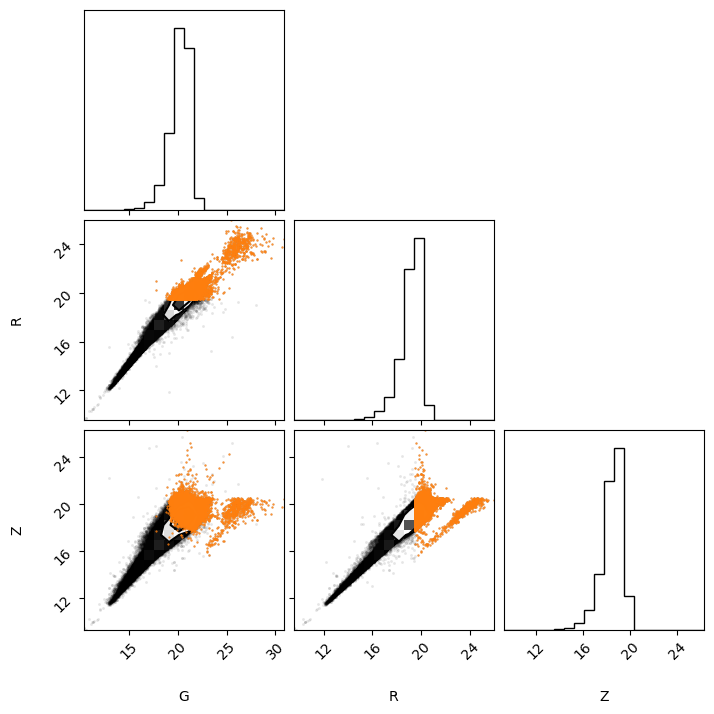

In [159]:
figure = corner.corner(corner_plot_data, divergences = True)

In [160]:
diff = [app_mag_r[q]-app_mag_z[q] for q in range(len(app_mag_r))]

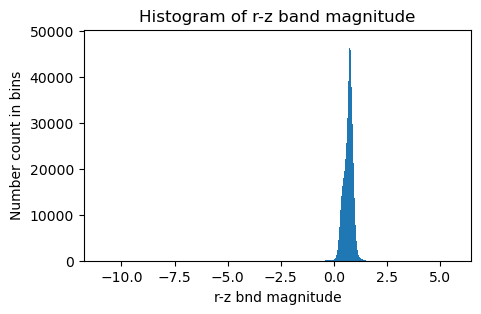

In [161]:
fig, ax = plt.subplots(figsize = (5,3))

ax.hist(diff, bins='auto')
ax.set_xlabel("r-z bnd magnitude")
ax.set_ylabel("Number count in bins")
plt.title("Histogram of r-z band magnitude")
plt.show()

In [162]:
avg_diff = np.mean(diff)

In [163]:
avg_diff

0.67338365

In [164]:
# However, since we only look at the z-band we need to correct the solar luminosity
# Calculation from here: https://astronomy.stackexchange.com/questions/25126/how-to-calculate-luminosity-in-g-band-from-absolute-ab-magnitude-and-luminosity
lmbda_z = 920*10**(-9) #in  m
del_lambda_z = 160*10**(-9) #in m
del_v_z = (asc.c*lmbda_z/(del_lambda_z**2)).value # this is in /s now

lmbda_r = 640*10**(-9) #in  m 5600A-7200A -> 6400A median
del_lambda_r = 160*10**(-9) #in m
del_v_r = (asc.c*lmbda_r/(del_lambda_r**2)).value # this is in /s now


m_sun_z = -27.56 # in z-band: http://mips.as.arizona.edu/~cnaw/sun.html (DES filter)
m_sun_r = -27.12 # in r-band: http://mips.as.arizona.edu/~cnaw/sun.html (DES filter)

f_v_z = 10**((-48.6-m_sun_z)/2.5) # in erg/(cm^2 s Hz)
f_v_r = 10**((-48.6-m_sun_r)/2.5) # in erg/(cm^2 s Hz)

dist_sun = 1.496*10**13 # in cm

L_sun_z = f_v_z*del_v_z*4*np.pi*dist_sun**2 *10**(-7) # this is  in Watts now
L_sun_r = f_v_r*del_v_r*4*np.pi*dist_sun**2 *10**(-7)
# the value is roughly half of the full bolometric value... not sure if this makes sense
print(L_sun_z, L_sun_r)

def lum_z(M):
    return L_sun_z*10**(-0.4*M)*u.W

def lum_r(M):
    return L_sun_r*10**(-0.4*M)*u.W

1.1626302434227454e+28 5.393041505438384e+27


In [165]:
lums_z = lum_z(abs_mag_z)

In [166]:
lums_r = lum_r(abs_mag_r)

In [167]:
offset = 0

In [168]:
m_limit_z = 19.5-avg_diff+offset # r-band magnitude limit for BGS Bright, would need to convert it to z-band magnitude

In [169]:
m_limit_z

18.82661634683609

In [170]:
m_limit_r = 19.5

In [171]:
lumin_limits_r = lum_lim(lums_r, m_limit_r, app_mag_r)

In [172]:
lumin_limits_z = lum_lim(lums_z, m_limit_z, app_mag_z)

In [173]:
# cornerplot (corner, chainconsumer) to see whether I miss peculiar galaxies
# redshift

In [174]:
ztile_cat = hstack([ztile_cat, Table({"APP_MAG_G": app_mag_g}),  Table({"APP_MAG_R": app_mag_r}), Table({'APP_MAG_Z': app_mag_z}), Table({'ABS_MAG_R': abs_mag_r}), Table({'ABS_MAG_Z': abs_mag_z}), Table({"LUM_Z": lums_z}), Table({"LUM_R": lums_r}), Table({'LUM_LIMIT_Z': lumin_limits_z}), Table({'LUM_LIMIT_R': lumin_limits_r})])

In [175]:
ztile_cat

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627794770034947,main,bright,20210609,0.3434721391420429,1.342083221411785e-05,0,GALAXY,238.50759776555574,0.34570032896999453,5.2453914,15.696667,32.585148,20.700556,19.51048,18.717451,-21.853648921320655,-22.646678706476905,1.3308009390017957e+37,2.973673832580578e+36,1.2035025879201784e+37,3.002518292362612e+36
39627800814030770,main,bright,20210609,0.3364164868317523,8.804215398699183e-05,0,GALAXY,238.86925764320216,0.5462878205990764,2.6192536,12.288538,28.288542,21.454556,19.776249,18.870974,-21.53547611587976,-22.440751460728393,1.1008856235937366e+37,2.2183200729538803e+36,1.1467932163659014e+37,2.861039131900351e+36
39627800814034117,main,bright,20210609,0.05057095057762226,3.4408071768163042e-06,0,GALAXY,238.97427987123274,0.5936892383771224,15.881108,21.43084,26.615164,19.497799,19.172401,18.937178,-17.660648326042995,-17.895872096184597,1.6741349172013262e+35,6.253067158915928e+34,1.8535956388198926e+35,4.624381613131109e+34
39627806853832150,main,bright,20210609,0.20535005655734515,6.544560905644702e-05,0,GALAXY,238.98559207893408,0.6532164248555011,6.4470363,21.232624,44.302246,20.4766,19.182491,18.383936,-20.908032215350687,-21.706587589496195,5.598564059654624e+36,1.2446482958443069e+36,3.72395555455377e+36,9.290587524928386e+35
39627794770035576,main,bright,20210609,0.5576890809194137,4.030136486491741e-05,0,GALAXY,238.53128524271153,0.31999237818547677,4.1716576,11.685528,24.258741,20.949228,19.83088,19.03783,-22.780445560658023,-23.5734944193006,3.124923454955416e+37,6.982516762238223e+36,3.7959897522385416e+37,9.470298394567037e+36
39627800809834103,main,bright,20210609,0.4583588870397052,3.54347398828501e-05,0,GALAXY,238.5556541498655,0.4011308785958288,2.4766326,7.069482,13.766501,21.515347,20.376532,19.65294,-21.724859751048,-22.44845060187808,1.1087199362605841e+37,2.6410563233394984e+36,2.373294401525084e+37,5.920934969853397e+36
39627800809833898,main,bright,20210609,0.07188346329477685,6.645182858719224e-06,0,GALAXY,238.54774476684366,0.47077639012926553,19.185844,34.291576,55.36728,19.292547,18.662031,18.141867,-18.967073407406744,-19.487237897152838,7.249979438860656e+35,2.0828746082376754e+35,3.858663612741718e+35,9.626659423137548e+34
39627800809834304,main,bright,20210609,0.45844369682435865,9.308965311007976e-05,0,GALAXY,238.56231240557304,0.4427502193462382,2.162092,13.665881,44.037453,21.662815,19.660906,18.390446,-22.44096331440722,-23.7114234431914,3.5482237075569103e+37,5.107625992906154e+36,2.3743391346302433e+37,5.923541159019292e+36


In [176]:
ztile_cat.group_by("ABS_MAG_R")[::-1]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627809538179853,main,bright,20211009,2.83018950524479e-08,1.7730281333380282e-05,0,GALAXY,38.773418551638045,1.1245661922530836,0.8246541,32.110233,88.385765,22.70932,18.73339,17.634045,13.241869632586502,12.14252347169783,1.6159660312664964e+23,2.723239950513654e+22,5.387701721535442e+22,1.3441329159492124e+22
39628324988783025,main,bright,20210522,5.2054327045416695e-08,4.411309715074355e-05,0,GALAXY,267.50916219267845,22.651541628046495,21.268328,26.34481,27.243828,19.180668,18.948261,18.911829,12.133533445343206,12.097101179107854,1.6850048078859155e+23,7.558234890421404e+22,1.8225784515580272e+23,4.5469993555291124e+22
39633424427780154,main,bright,20220120,7.06128087700978e-08,3.0034573295321535e-05,0,GALAXY,159.9077409235222,63.22227274565756,17.957848,15.056039,23.858559,19.364365,19.555723,19.05589,12.078862091394585,11.57902803072564,2.715378679792359e+23,7.948568588341971e+22,3.353818348940826e+23,8.3671628590642e+22
39633426772398076,main,bright,20211117,8.832994399959636e-08,1.5572978360394045e-06,0,GALAXY,109.70193892522676,63.550657203274625,134.2298,63.274323,114.605804,17.180378,17.996931,17.351984,10.033947606137959,9.389000554136006,2.0409924321461913e+24,5.2270267206441935e+23,5.247935046118533e+23,1.3092637638167052e+23
39628217203564121,main,bright,20220518,2.453286088901789e-07,7.156022637657443e-05,0,GALAXY,261.0566767736198,17.906628533141106,6.3465905,10.276418,20.896223,20.493649,19.970396,19.199831,9.789211104977186,9.018646072018202,2.870669448146994e+24,6.548612921252988e+23,4.048266306904983e+24,1.0099682832160275e+24
39628476315074855,main,bright,20220513,2.2471759018066488e-07,2.4475387299718475e-05,0,GALAXY,237.23672206725755,29.758537520441035,21.440014,18.098995,13.068511,19.171938,19.355864,19.709435,9.36523430497782,9.718805243088172,1.5063278954690132e+24,9.67698439445957e+23,3.3966187393144426e+24,8.47394140217541e+23
39633465817172969,main,bright,20210629,3.3733052615786944e-07,3.833683214212986e-05,0,GALAXY,260.8141439036602,67.28394587456856,5.6187196,14.958575,28.718401,20.625906,19.562775,18.854599,8.69005233069856,7.981876671518872,7.459177596258753e+24,1.802240854635345e+24,7.653922002643773e+24,1.9095132492546722e+24
39628147603275838,main,bright,20210613,2.9727563450556354e-07,3.684754290054296e-05,0,GALAXY,258.62073601040873,15.019142229559733,14.088809,21.664541,26.859493,19.627815,19.160625,18.927256,8.562384841797401,8.329015014526894,5.417957702708983e+24,2.0271217151249843e+24,5.944171966967643e+24,1.4829619911496105e+24


In [253]:
ztile_cat_r_cut = ztile_cat

In [254]:
len(ztile_cat_r_cut)

6939079

In [255]:
ztile_cat_r_cut = ztile_cat[ztile_cat["APP_MAG_R"] < m_limit_r]

In [256]:
len(ztile_cat_r_cut)

4300884

In [258]:
ztile_cat_r_cut  = ztile_cat_r_cut[ztile_cat_r_cut["Z"]>0.02]
ztile_cat_r_cut  = ztile_cat_r_cut[ztile_cat_r_cut["Z"]<0.6]

In [259]:
len(ztile_cat_r_cut)

4260234

In [260]:
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]< 0.6]
# ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]> 0.1]

In [261]:
# ztile_cat_r_cut = ztile_cat_r_cut[ztile_cat_r_cut["Z"] > 0.1]

In [262]:
z_max_data = np.max(ztile_cat_r_cut["Z"])
z_min_data = np.min(ztile_cat_r_cut["Z"])
print("z min and max in sample: ", z_min_data, z_max_data)

z min and max in sample:  0.02000172125340918 0.5999935242288166


In [263]:
ztile_cat_r_cut

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627800814034117,main,bright,20210609,0.05057095057762226,3.4408071768163042e-06,0,GALAXY,238.97427987123274,0.5936892383771224,15.881108,21.43084,26.615164,19.497799,19.172401,18.937178,-17.660648326042995,-17.895872096184597,1.6741349172013262e+35,6.253067158915928e+34,1.8535956388198926e+35,4.624381613131109e+34
39627806853832150,main,bright,20210609,0.20535005655734515,6.544560905644702e-05,0,GALAXY,238.98559207893408,0.6532164248555011,6.4470363,21.232624,44.302246,20.4766,19.182491,18.383936,-20.908032215350687,-21.706587589496195,5.598564059654624e+36,1.2446482958443069e+36,3.72395555455377e+36,9.290587524928386e+35
39627800809833898,main,bright,20210609,0.07188346329477685,6.645182858719224e-06,0,GALAXY,238.54774476684366,0.47077639012926553,19.185844,34.291576,55.36728,19.292547,18.662031,18.141867,-18.967073407406744,-19.487237897152838,7.249979438860656e+35,2.0828746082376754e+35,3.858663612741718e+35,9.626659423137548e+34
39627800805644591,main,bright,20210609,0.3995698156040027,0.00010358593919617879,0,GALAXY,238.45010756064576,0.38197122991464705,5.4006557,31.975393,85.936165,20.668884,18.73796,17.66456,-23.010702849326442,-24.084103346762966,5.00130055876505e+37,8.63206898430126e+36,1.7149859469263864e+37,4.2785757465299284e+36
39627800805645550,main,bright,20210609,0.1949191436125688,8.731670676715399e-06,0,GALAXY,238.48098242125738,0.4818731730539087,8.42878,17.441359,30.110353,20.185589,19.39605,18.803211,-20.568228258554,-21.161066545907516,3.3874136590878744e+36,9.101753429482591e+35,3.3151730511860814e+36,8.270749681484116e+35
39627800814031490,main,bright,20210609,0.07185348993713707,2.179654947232196e-06,0,GALAXY,238.8906323412064,0.4825049414117846,31.183992,54.977596,84.01239,18.765171,18.149536,17.689142,-19.478617929866374,-19.939011835506022,1.099123137506095e+36,3.3364216804358415e+35,3.855287079033069e+35,9.618234772793508e+34
39627800814032250,main,bright,20210609,0.08880965563053493,2.073611729100794e-05,0,GALAXY,238.91538743634203,0.5238096399672825,164.72557,363.29105,667.39343,16.958097,16.099363,15.439045,-22.013937807747745,-22.674256182381534,1.3650359492295998e+37,3.4467428692519355e+36,6.02719949916374e+35,1.5036758896146817e+35
39627812902011811,main,bright,20210609,0.20326918016152312,3.3393101947028825e-05,0,GALAXY,239.2853445362934,0.8926061595380618,8.174518,24.801294,59.551025,20.218845,19.013813,18.062777,-21.052006661630337,-22.003043114877407,7.356290344040627e+36,1.4211385728790715e+36,3.640180985053701e+36,9.081584546191193e+35


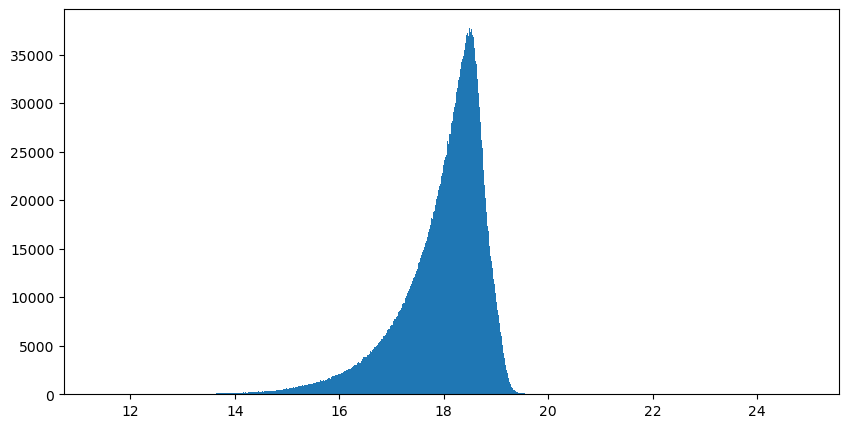

In [264]:
fig, ax = plt.subplots(figsize = (10,5))

ax.hist(ztile_cat_r_cut["APP_MAG_Z"], bins = "auto")
ax.vlines(m_limit_z, 0, 4000)

plt.show()

In [265]:
corner_plot_data = {"G": ztile_cat_r_cut["APP_MAG_G"], "R": ztile_cat_r_cut["APP_MAG_R"], "Z": ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

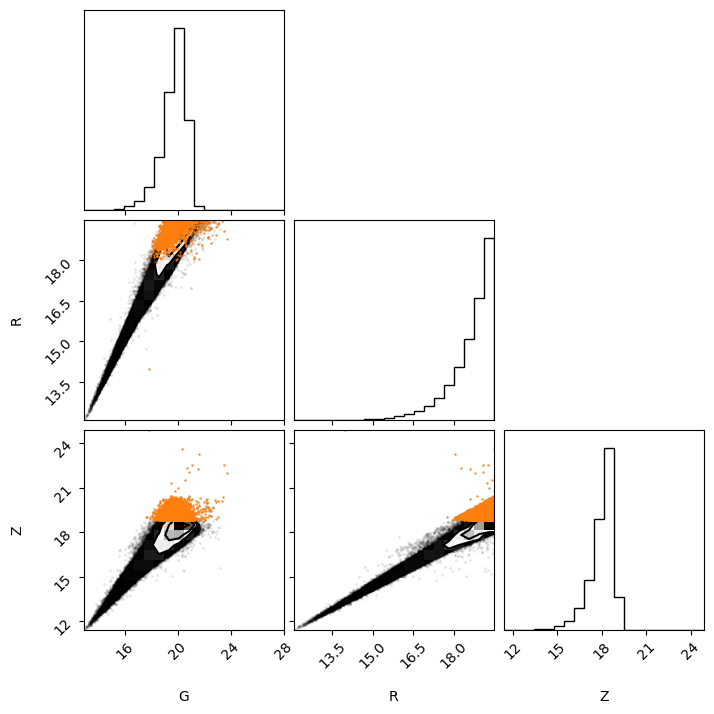

In [266]:
figure = corner.corner(corner_plot_data, divergences = True)

In [267]:
corner_plot_data = {"G-R": ztile_cat_r_cut["APP_MAG_G"]-ztile_cat_r_cut["APP_MAG_R"], "R-Z": ztile_cat_r_cut["APP_MAG_R"] - ztile_cat_r_cut["APP_MAG_Z"]}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z})

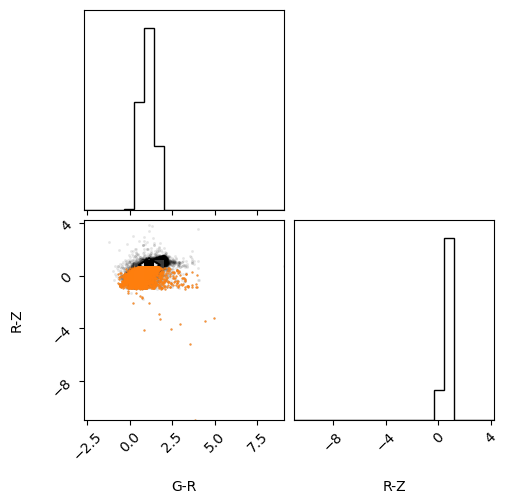

In [268]:
figure = corner.corner(corner_plot_data, divergences = True)

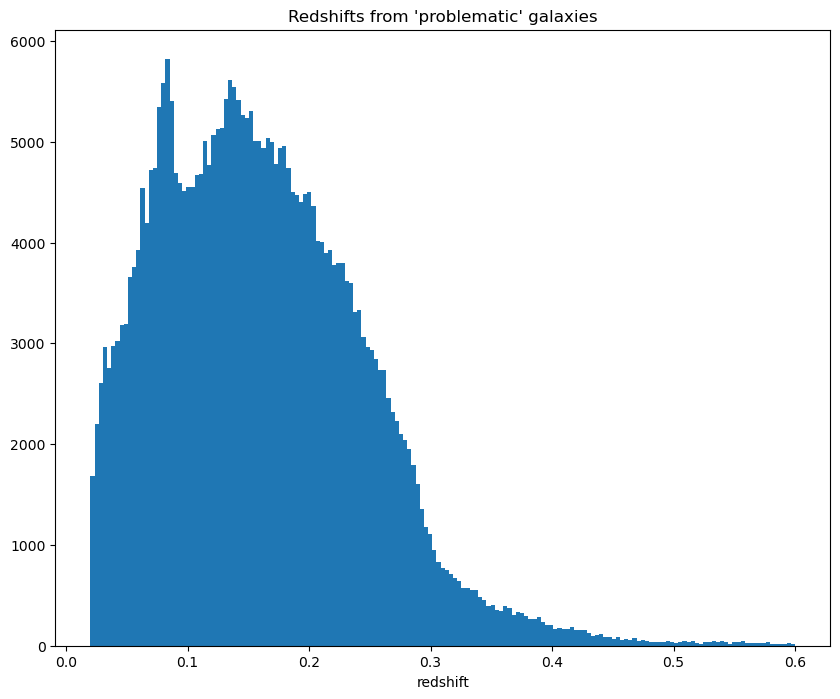

In [269]:
fig, ax = plt.subplots(figsize = (10,8))

ax.hist(ztile_cat_r_cut["Z"][ztile_cat_r_cut["APP_MAG_Z"]>m_limit_z], bins = "auto")
ax.set_xlabel("redshift")
plt.title("Redshifts from 'problematic' galaxies")
plt.show()

In [270]:
len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z]), len(ztile_cat_r_cut), len(ztile_cat_r_cut[ztile_cat_r_cut["APP_MAG_R"]>m_limit_z])/len(ztile_cat_r_cut)

(2273218, 4260234, 0.5335899389564047)

In [271]:
ztile_cat_grouped_by_AppMag = ztile_cat_r_cut.group_by("APP_MAG_R")

In [272]:
ztile_cat_grouped_by_AppMag

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
39628427904417989,sv3,bright,20210407,0.02452926313111436,1.0264717408780535e-05,0,GALAXY,194.35145922049065,27.49780503270462,6857.786,14788.432,27467.139,12.90954,12.075194,11.402967,-23.14576727252109,-23.817994178343845,3.9141664255095552e+37,9.77553807697684e+36,4.1993274263290545e+34,1.0476552380470937e+34
39627969127253006,main,bright,20220419,0.024544046726322488,5.966889515505232e-06,0,GALAXY,214.53844952675536,7.564536759237859,6338.3755,14347.159,26570.107,12.995055,12.108086,11.439017,-23.114208061669267,-23.783276398156083,3.79098595382693e+37,9.495481398720071e+36,4.204481255842524e+34,1.0489410970420863e+34
39627731532514190,main,bright,20220205,0.029458797644051855,1.5138868332320103e-05,0,GALAXY,69.2817158838786,-2.3046084837581726,5971.9106,13817.872,26571.746,13.059717,12.148897,11.438951,-23.477600176965396,-24.18754680935065,5.501236803560023e+37,1.327008893458684e+37,6.100900138203448e+34,1.5220632924772966e+34
39627760913616335,main,bright,20220113,0.027136413402110766,6.108009818466532e-06,0,GALAXY,20.59914382981807,-0.8751674946182008,6302.4824,13385.562,25160.797,13.001221,12.183409,11.498189,-23.261069037060835,-23.946288801770308,4.40511384524536e+37,1.087079679097752e+37,5.159245030753014e+34,1.287137451230112e+34
39628417133447721,sv1,bright,20210402,0.027813659888713448,2.705202154846243e-06,0,GALAXY,193.57922538261002,27.06803071919344,5968.879,12903.71,23318.602,13.060268,12.223214,11.580744,-23.27587434587,-23.918344705672247,4.293183962070856e+37,1.1020048376850713e+37,5.425383864653844e+34,1.3535338288966763e+34
39628417133447721,sv3,bright,20210416,0.02781992581233933,9.730440132466578e-06,0,GALAXY,193.57922538261002,27.06803071919344,5968.879,12903.71,23318.602,13.060268,12.223214,11.580744,-23.27637349298847,-23.918843852790715,4.295158127670287e+37,1.1025115804802097e+37,5.427878657861854e+34,1.354156234073418e+34
39628417133447721,sv3,bright,20210506,0.027859396774323555,8.782773977707215e-06,0,GALAXY,193.57922538261002,27.06803071919344,5968.879,12903.71,23318.602,13.060268,12.223214,11.580744,-23.27951524010578,-23.921985599908027,4.307604837455334e+37,1.1057064900199742e+37,5.443607818091748e+34,1.358080371240928e+34
39632976203484267,main,bright,20220514,0.024041862878378048,9.854647789661673e-06,0,GALAXY,203.6050967666297,34.69043122070213,5654.614,12431.319,21320.857,13.118993,12.263707,11.677989,-22.912889979735183,-23.49860813464241,2.9166537157714947e+37,7.888415078647184e+36,4.0311951782036597e+34,1.0057095020525478e+34


In [273]:
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[::-1]

In [274]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.394422297909952e+36,2.0942546139256338e+36
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.2576169734420105e+37,8.127157636623595e+36
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.733224186132934e+35,1.929297794419228e+35
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.696331477733109e+36,9.221670087098423e+35
39628476700950758,main,bright,20220516,0.3259818141363389,6.238839403178226e-05,0,GALAXY,263.6795480562096,29.86452318803688,3.723798,15.848975,34.660423,21.072535,19.499996,18.650415,-21.73234125303462,-22.581922017805127,1.2537484905573515e+37,2.6593179432084494e+36,1.0659334511695869e+37,2.6593085912540695e+36


In [275]:
ztile_cat_grouped_by_AppMag_sel = ztile_cat_grouped_by_AppMag[:int(0.2*len(ztile_cat_grouped_by_AppMag))]

In [276]:
np.max(ztile_cat_grouped_by_AppMag["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag["LUM_R"]), np.max(ztile_cat_grouped_by_AppMag_sel["LUM_R"]), np.min(ztile_cat_grouped_by_AppMag_sel["LUM_R"])

(1.79594702141538e+39,
 7.030270110489212e+33,
 1.348413834165045e+37,
 7.030270110489212e+33)

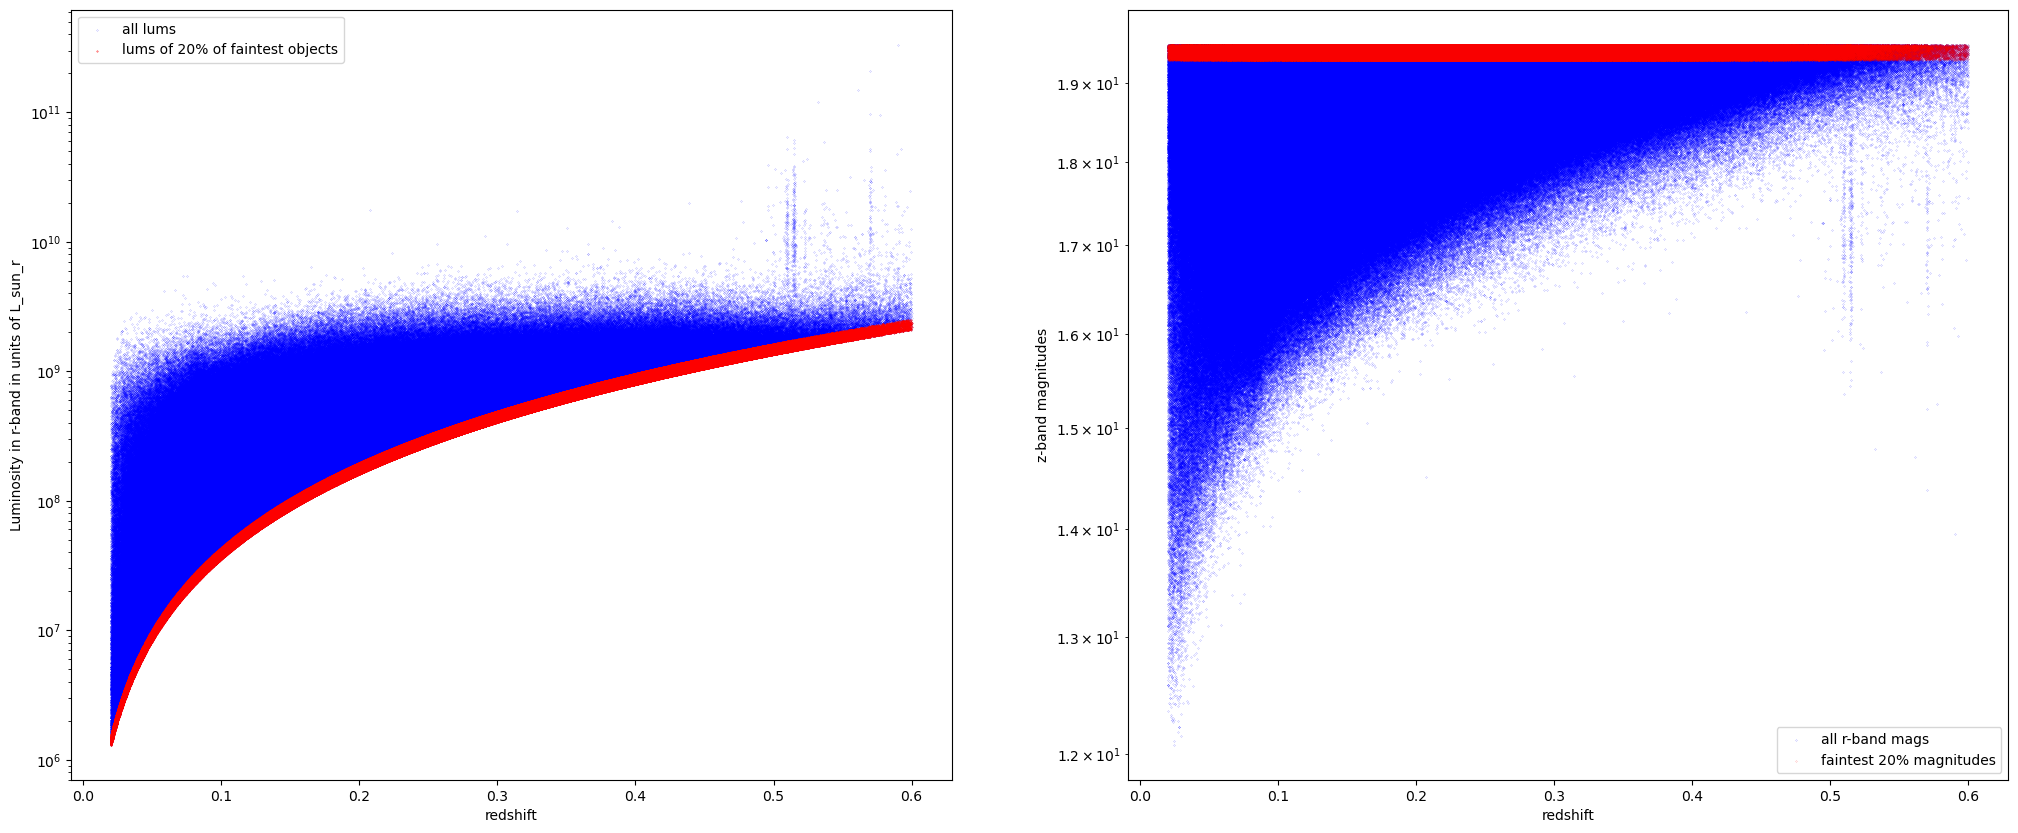

In [277]:
fig, ax = plt.subplots(ncols = 2, figsize = (25,10))

ax[0].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r), s = 0.01, color = "blue", label = "all lums")
ax[0].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/(L_sun_r), s = 0.1, color = "red", label ="lums of 20% of faintest objects")

ax[1].scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["APP_MAG_R"], s = 0.01, color = "blue", label = "all r-band mags")
ax[1].scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["APP_MAG_R"], s = 0.01, color = "red", label = "faintest 20% magnitudes")


ax[0].set_xlabel("redshift")
ax[0].set_ylabel("Luminosity in r-band in units of L_sun_r")
ax[0].set_yscale("log")
#ax.set_xlim(0.08,.6)
#ax.set_ylim(10**3,10**5)
ax[0].legend()

ax[1].set_xlabel("redshift")
ax[1].set_ylabel("z-band magnitudes")
ax[1].set_yscale("log")
ax[1].legend()

plt.show()

In [278]:
ztile_cat_grouped_by_AppMag_sel

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.394422297909952e+36,2.0942546139256338e+36
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.2576169734420105e+37,8.127157636623595e+36
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.733224186132934e+35,1.929297794419228e+35
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.696331477733109e+36,9.221670087098423e+35
39628476700950758,main,bright,20220516,0.3259818141363389,6.238839403178226e-05,0,GALAXY,263.6795480562096,29.86452318803688,3.723798,15.848975,34.660423,21.072535,19.499996,18.650415,-21.73234125303462,-22.581922017805127,1.2537484905573515e+37,2.6593179432084494e+36,1.0659334511695869e+37,2.6593085912540695e+36
39632980439731049,main,bright,20211119,0.3920554604374992,0.0001069086853427979,0,GALAXY,150.6531448929639,34.96696871050341,2.9577417,15.848981,37.448135,21.3226,19.499996,18.566425,-22.20016403625852,-23.133734898074927,2.084181685521736e+37,4.091658480477172e+36,1.6400579388828155e+37,4.091644091448006e+36
39628424783860798,main,bright,20211019,0.11867997911647223,2.984646281755426e-05,0,GALAXY,345.3853896159446,27.331097062096124,10.300225,15.848995,22.347721,19.967884,19.499996,19.126917,-19.2856263190302,-19.658705618956958,8.490316178431994e+35,2.793085886293674e+35,1.1195515616705876e+36,2.7930760639210415e+35
39627615086057546,main,bright,20220513,0.490846718071652,5.893963676066733e-05,0,GALAXY,308.8242043946035,-7.187308578420688,4.2860875,15.848987,36.812595,20.919847,19.499996,18.585009,-22.778667523569403,-23.693655087656317,3.4906286675552137e+37,6.971091322503736e+36,2.7942198676456935e+37,6.97106680744784e+36


In [279]:
lower_limit_z = np.min(ztile_cat_grouped_by_AppMag["Z"]) # np.min(faint_mags["Z"]) # get the limits of redshift in this sample
upper_limit_z = np.max(ztile_cat_grouped_by_AppMag["Z"]) # np.max(faint_mags["Z"])
delta_z = 0.005
bins = np.arange(lower_limit_z, upper_limit_z, delta_z)
num_of_bins_z = len(bins)

In [280]:
lower_limit_z, upper_limit_z, num_of_bins_z

(0.02000172125340918, 0.5999935242288166, 116)

In [281]:
LUM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin
LUM_LIM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin

cnt = 0
for bins_left_edge in bins[:num_of_bins_z-1]:
    # this is where we select all the galaxies that lie in the z range ([start, stop))
    
    # z-range selection
    ii = ztile_cat_grouped_by_AppMag_sel['Z']>=(bins_left_edge)
    ii &= ztile_cat_grouped_by_AppMag_sel['Z']<(bins_left_edge+delta_z)
    dat = ztile_cat_grouped_by_AppMag_sel[ii]

    # select only z-band luminosity (limit)
    LUM = dat["LUM_R"]
    LUM_LIM = dat["LUM_LIMIT_R"]
    
    # sort this data ascending
    LUM = np.sort(LUM)
    LUM_LIM = np.sort(LUM_LIM)
    
    # impose the same cut as in the paper, at 95%. This is the mass limit value
    LUM_cut = int(0.95*len(LUM))
    LUM_LIM_cut = int(0.95*len(LUM_LIM))

    # if there was no data in this bin, just store a 0
    if len(LUM) == 0:
        LUM = [0]
    if len(LUM_LIM) == 0:
        LUM_LIM = [0]
    
    # now store this luminosity (limit) value for the whole redshift range
    LUM_95[cnt] = LUM[LUM_cut] # this is the 95% lum per bin
    LUM_LIM_95[cnt] = LUM_LIM[LUM_LIM_cut] # this is the "Luminosity Limit" value per bin
    cnt += 1

In [282]:
stop_at = np.argmin(LUM_LIM_95[1:])
if stop_at == 0:
    stop_at = len(LUM_LIM_95)

In [283]:
stop_at

115

Fit values:  7251562630.908631 -993318577.5495119 58433580.69203088


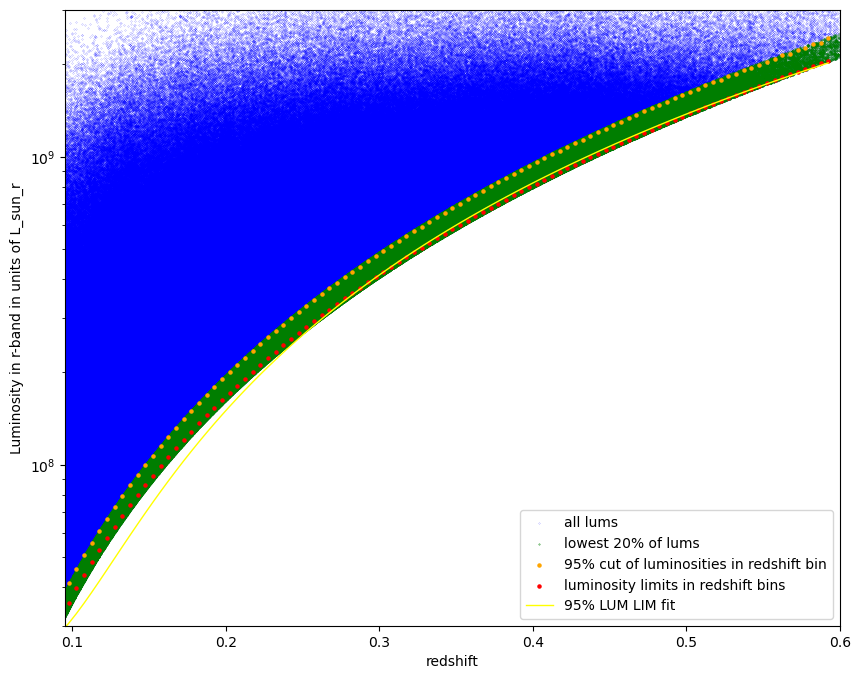

In [284]:
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r), s = 0.01, color = "blue", label = "all lums")
ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_R"]/(L_sun_r), s = 0.1, color = "green", label ="lowest 20% of lums")

center_z = (bins[:-1] + bins[1:])/2
ax.scatter(center_z, LUM_95/(L_sun_r), s = 5, color = "orange", label = "95% cut of luminosities in redshift bin")
ax.scatter(center_z, LUM_LIM_95/(L_sun_r), s = 5, color = "red", label ="luminosity limits in redshift bins")

def poly2d(x, a, b, c):
    return a*x**2 + b*x + c

def poly3d(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# for the fit to be good, we need to decrease the LUM values, otherwise, they fit doesn't work that well
# normalize_LUM = 10**(7)

coefs_LUM_LIM_95, _ = curve_fit(poly2d, center_z[:int(stop_at)], LUM_LIM_95[:int(stop_at)]/(L_sun_r))
print("Fit values: ", coefs_LUM_LIM_95[0], coefs_LUM_LIM_95[1], coefs_LUM_LIM_95[2])

ax.plot(center_z, poly2d(center_z, *coefs_LUM_LIM_95), linewidth = 1, color = "yellow", label = "95% LUM LIM fit")

ax.set_xlabel("redshift")
ax.set_ylabel("Luminosity in r-band in units of L_sun_r")
ax.set_yscale("log")
ax.set_xlim(0.095, 0.6)
ax.set_ylim(3*10**7,3*10**9)
ax.legend()
plt.show()

In [285]:
def poly3d_inverse(x, a, b, c, d):
    # x is (as its the inverse) the y
    
    p = -b/(3*a)
    q = p**3+(b*c-3*a*(d-x))/(6*a**2)
    r = c/(3*a)
    
    return (q+(q**2+(r-p**2)**3)**0.5)**(1/3) + (q-(q**2+(r-p**2)**3)**0.5)**(1/3) + p

In [286]:
poly3d(10,  5,4,3,2)

5432

In [287]:
poly3d_inverse(5432,  5,4,3,2)

(10.018808198145702+0.010858918244541459j)

invert to get zmax

$$ax^2+bx+c = a(x-h)^2+k$$ with $$h = -\frac{b}{2a} \text{ and } k = c-ah^2$$

i.e. the inverse of a quadratic is:

$$ f^{-1}(x) = \pm\sqrt{\frac{x-k}{a}}+h$$

To reproduce the physically correct results one has to take the negative solution!

/tmp/ipykernel_26703/318589281.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((x-k)/a)+h


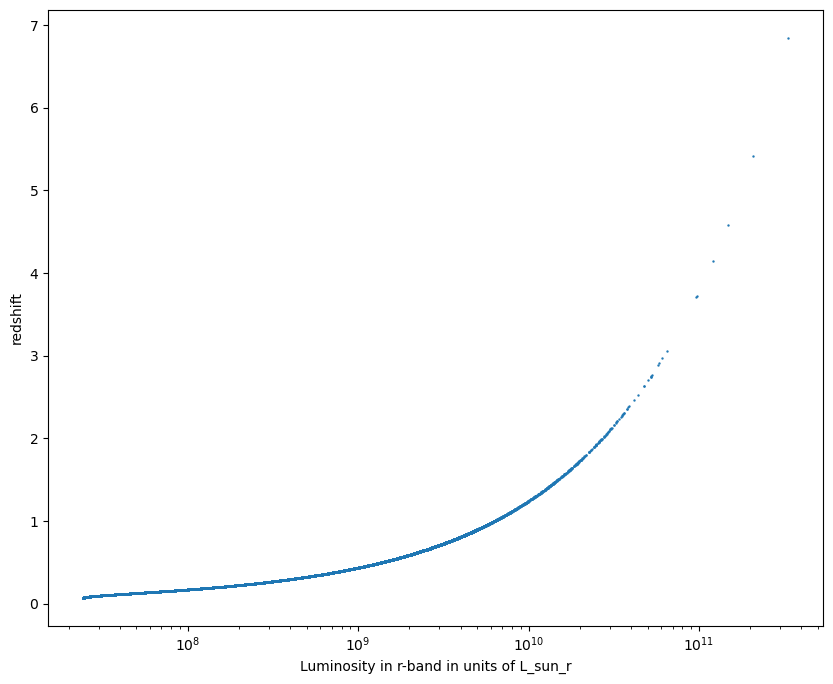

In [288]:
# now plot the inverse:

# from here we can get the z_max values, i.e. the maximum redshift at a certain luminosity that an object could be detected

# inverse is as above

def poly2d_inverse(x, a,h,k):
    return np.sqrt((x-k)/a)+h

a = coefs_LUM_LIM_95[0]
b = coefs_LUM_LIM_95[1]
c = coefs_LUM_LIM_95[2]
h = -b/(2*a)
k = c-a*h**2
inverted_coefs_95 = [a,h,k]

fig, ax = plt.subplots(figsize = (10,8))

#ax.scatter(LUM_LIM_95/(L_sun_z), center_z, s = 3, color = "red", label ="Calculated luminosity limits, including a offseted z-band magnitude limit")

ax.scatter(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r), poly2d_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r), *inverted_coefs_95), s = 0.5)
#ax.vlines(LUM_LIM_95[stop_at-1]/(L_sun_z), 0, 1, label = "limit of fit")


ax.set_xlabel("Luminosity in r-band in units of L_sun_r")
ax.set_ylabel("redshift")
ax.set_xscale("log")
#ax.set_ylim(0,1)
#ax.set_xlim(10,10**5)
#ax.legend()
plt.show()

In [289]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R
,,,,,,,,,,,,,,,,,,W,W,W,W
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.394422297909952e+36,2.0942546139256338e+36
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.2576169734420105e+37,8.127157636623595e+36
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.733224186132934e+35,1.929297794419228e+35
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.696331477733109e+36,9.221670087098423e+35
39628476700950758,main,bright,20220516,0.3259818141363389,6.238839403178226e-05,0,GALAXY,263.6795480562096,29.86452318803688,3.723798,15.848975,34.660423,21.072535,19.499996,18.650415,-21.73234125303462,-22.581922017805127,1.2537484905573515e+37,2.6593179432084494e+36,1.0659334511695869e+37,2.6593085912540695e+36


In [290]:
np.max(ztile_cat_grouped_by_AppMag["ABS_MAG_R"]), np.min(ztile_cat_grouped_by_AppMag["ABS_MAG_R"])

(-15.287845621798638, -28.806149396505127)

In [291]:
z_max_i = np.array(poly2d_inverse(ztile_cat_grouped_by_AppMag["LUM_R"]/(L_sun_r), *inverted_coefs_95))

/tmp/ipykernel_26703/318589281.py:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((x-k)/a)+h


In [292]:
np.min(z_max_i)

nan

In [293]:
z_max_i[:5], len(ztile_cat_grouped_by_AppMag)

(array([0.29250665, 0.52064753, 0.10806364, 0.21066195, 0.32271856]), 4260234)

In [294]:
ztile_cat_z_max = 5

In [295]:
ztile_cat_z_max = hstack([ztile_cat_grouped_by_AppMag, Table({"z_max": z_max_i})])

In [296]:
ztile_cat_z_max[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
,,,,,,,,,,,,,,,,,,W,W,W,W,
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.394422297909952e+36,2.0942546139256338e+36,0.2925066476726106
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.2576169734420105e+37,8.127157636623595e+36,0.5206475259958963
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.733224186132934e+35,1.929297794419228e+35,0.10806364027377302
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.696331477733109e+36,9.221670087098423e+35,0.2106619461278031
39628476700950758,main,bright,20220516,0.3259818141363389,6.238839403178226e-05,0,GALAXY,263.6795480562096,29.86452318803688,3.723798,15.848975,34.660423,21.072535,19.499996,18.650415,-21.73234125303462,-22.581922017805127,1.2537484905573515e+37,2.6593179432084494e+36,1.0659334511695869e+37,2.6593085912540695e+36,0.3227185649164171


In [297]:
#only allow redshifts above 0.1
ztile_cat_z_max = ztile_cat_z_max[ztile_cat_z_max["z_max"] > 0.1]

In [298]:
ztile_cat_z_max[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max
,,,,,,,,,,,,,,,,,,W,W,W,W,
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.394422297909952e+36,2.0942546139256338e+36,0.2925066476726106
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.2576169734420105e+37,8.127157636623595e+36,0.5206475259958963
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.733224186132934e+35,1.929297794419228e+35,0.10806364027377302
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.696331477733109e+36,9.221670087098423e+35,0.2106619461278031
39628476700950758,main,bright,20220516,0.3259818141363389,6.238839403178226e-05,0,GALAXY,263.6795480562096,29.86452318803688,3.723798,15.848975,34.660423,21.072535,19.499996,18.650415,-21.73234125303462,-22.581922017805127,1.2537484905573515e+37,2.6593179432084494e+36,1.0659334511695869e+37,2.6593085912540695e+36,0.3227185649164171


In [299]:
np.min(ztile_cat_z_max["Z"]), np.max(ztile_cat_z_max["Z"])

(0.02000172125340918, 0.5999935242288166)

In [300]:
V_max_i = V_max(area, z_min_data, ztile_cat_z_max["z_max"])

In [301]:
len(V_max_i)

4065426

In [302]:
len(ztile_cat_z_max)

4065426

In [303]:
V_max_i[:5]

<Quantity [1.14716786e+08, 8.75658347e+08, 4.18021257e+06, 3.75385599e+07,
           1.61198576e+08] Mpc3>

In [304]:
ztile_wVmax = hstack([ztile_cat_z_max, Table({"V_MAX": V_max_i})])

In [305]:
ztile_wVmax

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,SPECTYPE,TARGET_RA,TARGET_DEC,FLUX_G,FLUX_R,FLUX_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,ABS_MAG_Z,LUM_Z,LUM_R,LUM_LIMIT_Z,LUM_LIMIT_R,z_max,V_MAX
,,,,,,,,,,,,,,,,,,W,W,W,W,,Mpc3
int64,bytes7,bytes6,int32,float64,float64,int64,bytes6,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64
39627744803293140,main,bright,20220210,0.29393356192632125,5.053998841406768e-06,0,GALAXY,140.3418958135519,-1.7572070594922846,8.420731,15.848966,24.012398,20.186626,19.499998,19.048912,-21.47299117234912,-21.924077216660642,6.840258315172543e+36,2.0942582339236586e+36,8.394422297909952e+36,2.0942546139256338e+36,0.2925066476726106,114716786.34337059
39628512461591304,main,bright,20220317,0.5233237733268103,0.00014110804655666955,0,GALAXY,217.16345402810097,31.558060747908186,2.8993962,15.848956,46.282883,21.34423,19.499998,18.336449,-22.945264178866502,-24.108813602084275,5.116430237192587e+37,8.127171684721852e+36,3.2576169734420105e+37,8.127157636623595e+36,0.5206475259958963,875658347.1250027
39627603929204288,main,bright,20211021,0.09985713084547924,9.501685612959509e-06,0,GALAXY,359.06996685968784,-7.731517222708435,9.3054495,15.848953,23.134731,20.078156,19.499998,19.089338,-18.883915639575875,-19.294575429614937,6.071161529616348e+35,1.9293011292831737e+35,7.733224186132934e+35,1.929297794419228e+35,0.10806364027377302,4180212.5729991077
39628121997053964,main,bright,20220122,0.2046669597299606,6.631007630176025e-05,0,GALAXY,124.08490860435361,14.009380623384853,5.1329536,15.848953,30.459774,20.724081,19.499998,18.790684,-20.582441422326326,-21.291755768639803,3.820708666564449e+36,9.221686027102699e+35,3.696331477733109e+36,9.221670087098423e+35,0.2106619461278031,37538559.92453926
39628476700950758,main,bright,20220516,0.3259818141363389,6.238839403178226e-05,0,GALAXY,263.6795480562096,29.86452318803688,3.723798,15.848975,34.660423,21.072535,19.499996,18.650415,-21.73234125303462,-22.581922017805127,1.2537484905573515e+37,2.6593179432084494e+36,1.0659334511695869e+37,2.6593085912540695e+36,0.3227185649164171,161198576.0452808
39632980439731049,main,bright,20211119,0.3920554604374992,0.0001069086853427979,0,GALAXY,150.6531448929639,34.96696871050341,2.9577417,15.848981,37.448135,21.3226,19.499996,18.566425,-22.20016403625852,-23.133734898074927,2.084181685521736e+37,4.091658480477172e+36,1.6400579388828155e+37,4.091644091448006e+36,0.3866997359991451,303535281.3704355
39628424783860798,main,bright,20211019,0.11867997911647223,2.984646281755426e-05,0,GALAXY,345.3853896159446,27.331097062096124,10.300225,15.848995,22.347721,19.967884,19.499996,19.126917,-19.2856263190302,-19.658705618956958,8.490316178431994e+35,2.793085886293674e+35,1.1195515616705876e+36,2.7930760639210415e+35,0.12992931213931744,7597639.259091209
39627615086057546,main,bright,20220513,0.490846718071652,5.893963676066733e-05,0,GALAXY,308.8242043946035,-7.187308578420688,4.2860875,15.848987,36.812595,20.919847,19.499996,18.585009,-22.778667523569403,-23.693655087656317,3.4906286675552137e+37,6.971091322503736e+36,2.7942198676456935e+37,6.97106680744784e+36,0.4866827662249474,687270036.3471076


In [306]:
lower_limit_lum = np.min(ztile_wVmax["LUM_R"])
upper_limit_lum = np.max(ztile_wVmax["LUM_R"])
print("lower and upper limit of LUM_R: ", lower_limit_lum, upper_limit_lum)

num_of_lum_bins = 100

lum_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), num_of_lum_bins, endpoint = True)

print("num of bins", len(lum_bins))
print(lum_bins[0:10])

lower and upper limit of LUM_R:  1.7051380446908394e+35 1.79594702141538e+39
num of bins 100
[1.70513804e+35 1.87236796e+35 2.05599880e+35 2.25763908e+35
 2.47905504e+35 2.72218619e+35 2.98916220e+35 3.28232166e+35
 3.60423247e+35 3.95771440e+35]


In [307]:
len(lum_bins)

100

In [308]:
def calc_phi_j(V_max_i, lum_bins):
    
    phi_j = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["LUM_R"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_R"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        one_ov_dat = [1/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

In [309]:
phi_j = calc_phi_j(V_max_i, lum_bins)

In [310]:
len(phi_j)

99

In [311]:
phi_j[:5]

[0.005926243582613489,
 0.005361103755791328,
 0.0049752959190960755,
 0.004639670549526228,
 0.004339920297427052]

In [312]:
center_lum_bins = lum_bins[1:]-(lum_bins[2]-lum_bins[1])/2

In [313]:
len(center_lum_bins)

99

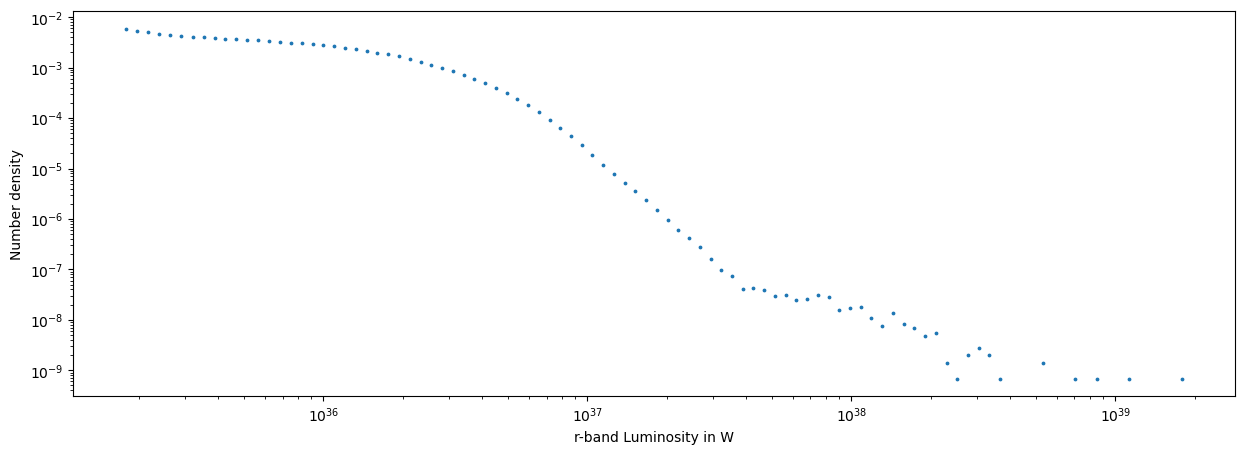

In [314]:
fig, ax = plt.subplots(figsize = (15,5))

ax.scatter(center_lum_bins, phi_j, s = 3)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("r-band Luminosity in W")
ax.set_ylabel("Number density")

plt.show()

In [315]:
# Fit a schechter function to the data
# for this we need to go from the Luminosities back to the magnitudes...

In [316]:
def M_r(L_r):
    return -2.5*np.log10(L_r/(L_sun_r))

In [317]:
len(center_lum_bins), len(phi_j)

(99, 99)

In [318]:
center_lum_bins, phi_j = np.array(center_lum_bins), np.array(phi_j)

In [319]:
center_lum_bins.shape, phi_j.shape

((99,), (99,))

In [320]:
center_lum_bins, phi_j

(array([1.78055254e+35, 1.96418338e+35, 2.16582366e+35, 2.38723962e+35,
        2.63037077e+35, 2.89734678e+35, 3.19050624e+35, 3.51241705e+35,
        3.86589898e+35, 4.25404834e+35, 4.68026511e+35, 5.14828271e+35,
        5.66220073e+35, 6.22652081e+35, 6.84618608e+35, 7.52662448e+35,
        8.27379627e+35, 9.09424628e+35, 9.99516121e+35, 1.09844326e+36,
        1.20707259e+36, 1.32635564e+36, 1.45733728e+36, 1.60116482e+36,
        1.75909812e+36, 1.93252060e+36, 2.12295133e+36, 2.33205838e+36,
        2.56167343e+36, 2.81380777e+36, 3.09066997e+36, 3.39468518e+36,
        3.72851642e+36, 4.09508786e+36, 4.49761047e+36, 4.93961014e+36,
        5.42495853e+36, 5.95790704e+36, 6.54312401e+36, 7.18573561e+36,
        7.89137079e+36, 8.66621051e+36, 9.51704196e+36, 1.04513180e+37,
        1.14772222e+37, 1.26037412e+37, 1.38407425e+37, 1.51990616e+37,
        1.66905967e+37, 1.83284128e+37, 2.01268562e+37, 2.21016804e+37,
        2.42701838e+37, 2.66513612e+37, 2.92660705e+37, 3.213721

In [321]:
fit_data = hstack([Table({"LUM": center_lum_bins}), Table({"ABS_MAG_R": M_r(center_lum_bins)}), Table({"N": phi_j})])

In [322]:
fit_data

LUM,ABS_MAG_R,N
float64,float64,float64
1.780552538619282e+35,-18.796802575531075,0.005926243582613489
1.9641833802239078e+35,-18.903370673240417,0.005361103755791328
2.1658236551874067e+35,-19.00947332525304,0.0049752959190960755
2.3872396228541204e+35,-19.1151556287334,0.004639670549526228
2.630370766900963e+35,-19.220458016494813,0.004339920297427052
2.897346784161406e+35,-19.325416791127616,0.0042049835192529495
3.1905062396136848e+35,-19.43006458905483,0.004067210960266613
3.512417050940256e+35,-19.534430785198076,0.003959635358404622
3.8658989820929694e+35,-19.638541847065277,0.0038483623896808897


In [323]:
fit_data = fit_data[fit_data["N"] != 0]

In [324]:
fit_data[:55]

LUM,ABS_MAG_R,N
float64,float64,float64
1.780552538619282e+35,-18.796802575531075,0.005926243582613489
1.9641833802239078e+35,-18.903370673240417,0.005361103755791328
2.1658236551874067e+35,-19.00947332525304,0.0049752959190960755
2.3872396228541204e+35,-19.1151556287334,0.004639670549526228
2.630370766900963e+35,-19.220458016494813,0.004339920297427052
2.897346784161406e+35,-19.325416791127616,0.0042049835192529495
3.1905062396136848e+35,-19.43006458905483,0.004067210960266613
3.512417050940256e+35,-19.534430785198076,0.003959635358404622
3.8658989820929694e+35,-19.638541847065277,0.0038483623896808897


In [325]:
np.array(fit_data["N"])

array([5.92624358e-03, 5.36110376e-03, 4.97529592e-03, 4.63967055e-03,
       4.33992030e-03, 4.20498352e-03, 4.06721096e-03, 3.95963536e-03,
       3.84836239e-03, 3.77419037e-03, 3.67414440e-03, 3.55899636e-03,
       3.44666108e-03, 3.32392414e-03, 3.21458635e-03, 3.13452310e-03,
       3.00958556e-03, 2.91051836e-03, 2.76242566e-03, 2.62126679e-03,
       2.48851038e-03, 2.34641051e-03, 2.16552828e-03, 1.98979439e-03,
       1.82181536e-03, 1.66280606e-03, 1.48767689e-03, 1.31270345e-03,
       1.14814040e-03, 9.89563082e-04, 8.48717843e-04, 7.18202891e-04,
       5.95027434e-04, 4.92176043e-04, 3.94179652e-04, 3.09917439e-04,
       2.37501941e-04, 1.80821846e-04, 1.32323277e-04, 9.36195506e-05,
       6.49699790e-05, 4.39113651e-05, 2.90479141e-05, 1.84510387e-05,
       1.15576266e-05, 7.60836400e-06, 5.24549680e-06, 3.56652748e-06,
       2.37859685e-06, 1.48474231e-06, 9.71818899e-07, 6.12088610e-07,
       4.21964997e-07, 2.76978645e-07, 1.62083799e-07, 9.77973980e-08,
      

In [326]:
# get model
Schechter = models.Schechter1D()
# set fitting algorithm
fit_alg = fitting.LMLSQFitter() # only this Fitter is able to fit, all others from here: https://docs.astropy.org/en/stable/modeling/fitting.html fail
# perform fit

fit_lim = len(fit_data)-1

schechter_fit = fit_alg(Schechter, np.array(fit_data["ABS_MAG_R"][:fit_lim]), np.array(fit_data["N"][:fit_lim]))

print(schechter_fit)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           phi_star              m_star              alpha       
    --------------------- ------------------- -------------------
    0.0032803618139088616 -21.742937294174332 -1.2274141220105506


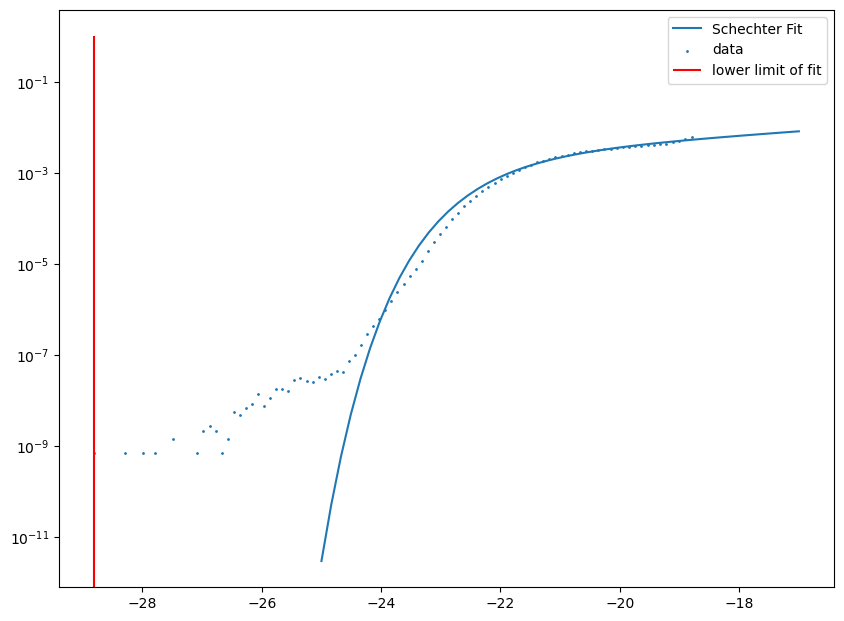

In [327]:
fig, ax = plt.subplots(figsize = (10,7.5))

x = np.linspace(-25, -17)

ax.plot(x, schechter_fit(x), label = "Schechter Fit")
ax.scatter(np.array(fit_data["ABS_MAG_R"]), np.array(fit_data["N"]), label = "data", s = 1)
ax.vlines(fit_data["ABS_MAG_R"][fit_lim], 0,1, label = "lower limit of fit", color = "red")


ax.set_yscale('log')
#ax.set_ylim(10**-23, 10**-1)
ax.legend()
plt.show()

In [328]:
np.max(np.array(fit_data["N"]))

0.005926243582613489

In [329]:
 0.00021404293387048377/0.0089

0.024049767850616154

In [330]:
# simple calculator for volume (assuming the sky area has already been calculated)
volume = area/3*(Distance(z=z_max_data, cosmology=Planck18)**3-Distance(z=z_min_data, cosmology=Planck18)**3)

In [331]:
print(volume)

4800145595451.962 Mpc3


In [332]:
from scipy import integrate

In [333]:
integrate.quad(schechter_fit, -25, -17)

(0.021839645925320852, 4.114597028943964e-14)

In [334]:
integrate.quad(schechter_fit, -25, -24)

(7.566057745390122e-08, 8.400011514575614e-22)